In [1]:
import pandas as pd

In [2]:
df_customers = pd.read_csv('olist_customers_dataset.csv')
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
df_order_items = pd.read_csv('olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv')
df_sellers = pd.read_csv('olist_sellers_dataset.csv')
df_product_category_name = pd.read_csv('product_category_name_translation.csv')

df_train = df_orders.merge(df_order_items, on='order_id', how='left')
df_train = df_train.merge(df_order_payments, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_order_reviews, on='order_id', how='outer')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_customers, on='customer_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')
df_train = df_train.merge(df_product_category_name, on='product_category_name', how='inner')

In [3]:
df_train.columns.tolist()

['order_id',
 'customer_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'order_item_id',
 'product_id',
 'seller_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'payment_sequential',
 'payment_type',
 'payment_installments',
 'payment_value',
 'review_id',
 'review_score',
 'review_comment_title',
 'review_comment_message',
 'review_creation_date',
 'review_answer_timestamp',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'product_category_name_english']

<ipython-input-4-769a317ae7a3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_year_data['quarter'] = quarters
<ipython-input-4-769a317ae7a3>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_year_data['profit'] = last_year_data['price'] - last_year_data['freight_value']
<ipython-input-4-769a317ae7a3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Train R^2 Score: 0.9956811579989415
Test R^2 Score: 0.9760797748362762


<ipython-input-4-769a317ae7a3>:87: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


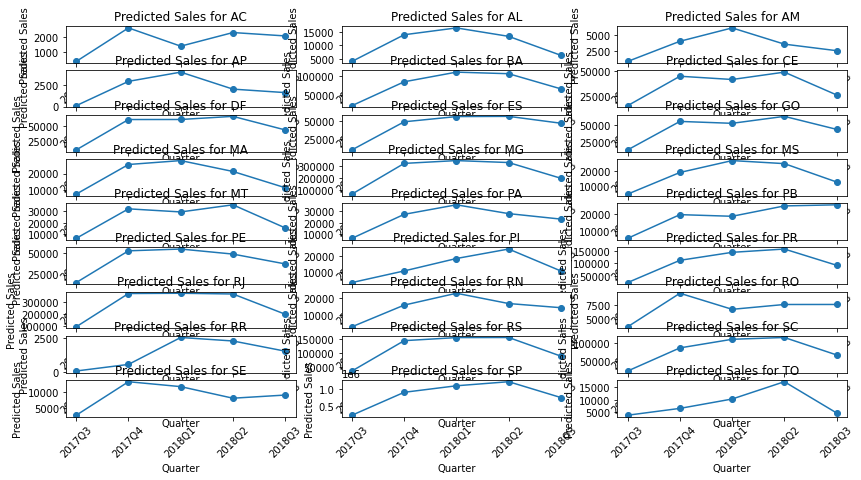

In [4]:
# DON'T USE but you can look through if you want

import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load the data
# Assuming df_train contains the provided dataframe

# Convert timestamp columns to datetime
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df_train[col] = pd.to_datetime(df_train[col])

# Filter data for the last year
last_year_data = df_train[df_train['order_purchase_timestamp'] >= df_train['order_purchase_timestamp'].max() - pd.DateOffset(years=1)]

# Split data into quarters
quarters = last_year_data['order_purchase_timestamp'].dt.to_period('Q').astype(str)  # Convert to string
last_year_data['quarter'] = quarters

# Calculate profit and revenue
last_year_data['profit'] = last_year_data['price'] - last_year_data['freight_value']
last_year_data['revenue'] = last_year_data['price'] + last_year_data['freight_value']

# Aggregate sales data by state, product category, and quarter
sales_data = last_year_data.groupby(['customer_state', 'product_category_name_english', 'quarter']).agg({
    'price': 'sum',
    'profit': 'sum',
    'revenue': 'sum'
}).reset_index()

# Prepare features and target variable
X = sales_data.drop(['price'], axis=1)  # Features: state, product category, profit, revenue, quarter
y = sales_data['price']  # Target variable: total sales

# Convert categorical variables into dummy variables
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
train_score = r2_score(y_train, model.predict(X_train))
test_score = r2_score(y_test, model.predict(X_test))
print("Train R^2 Score:", train_score)
print("Test R^2 Score:", test_score)

# Predict sales for each state
predictions = model.predict(X)

# Create a dataframe with predicted sales
predicted_sales = pd.DataFrame({
    'customer_state': sales_data['customer_state'],
    'product_category_name_english': sales_data['product_category_name_english'],
    'quarter': sales_data['quarter'],
    'predicted_sales': predictions
})

# Group by state and sum the predicted sales
predicted_sales_by_state = predicted_sales.groupby(['customer_state', 'quarter'])['predicted_sales'].sum().reset_index()

# Sort states by predicted sales
predicted_sales_by_state = predicted_sales_by_state.sort_values(by=['customer_state', 'quarter'], ascending=True)

# Visualize the results
plt.figure(figsize=(14, 8))

states = predicted_sales_by_state['customer_state'].unique()
num_states = len(states)

for i, state in enumerate(states):
    plt.subplot(num_states // 3 + 1, 3, i + 1)
    state_data = predicted_sales_by_state[predicted_sales_by_state['customer_state'] == state]
    plt.plot(state_data['quarter'], state_data['predicted_sales'], marker='o')
    plt.title(f'Predicted Sales for {state}')
    plt.xlabel('Quarter')
    plt.ylabel('Predicted Sales')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


<ipython-input-5-7b338eda4f73>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_last_four_months['profit'] = df_train_last_four_months['price'] - df_train_last_four_months['freight_value']
<ipython-input-5-7b338eda4f73>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_last_four_months['revenue'] = df_train_last_four_months['price'] + df_train_last_four_months['freight_value']


Train R^2 Score: 0.99983230490296
Test R^2 Score: 0.9593842631178966


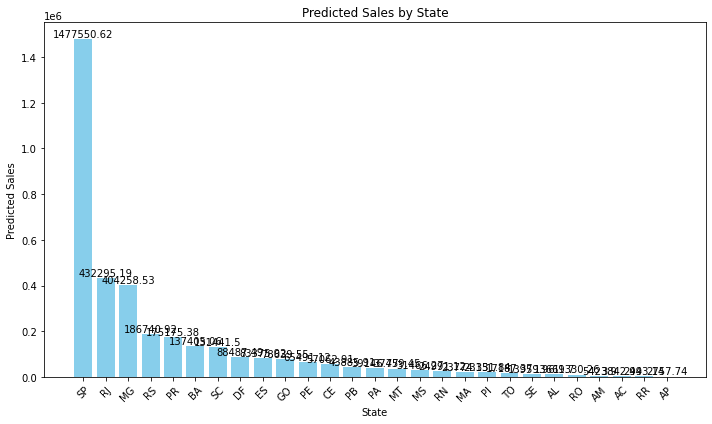

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load the data
# Assuming df_train contains the provided dataframe

# Convert 'order_purchase_timestamp' to datetime
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp'])

# Filter data for the last four months
last_four_months = df_train['order_purchase_timestamp'].max() - pd.DateOffset(months=4)
df_train_last_four_months = df_train[df_train['order_purchase_timestamp'] >= last_four_months]

# Calculate profit and revenue
df_train_last_four_months['profit'] = df_train_last_four_months['price'] - df_train_last_four_months['freight_value']
df_train_last_four_months['revenue'] = df_train_last_four_months['price'] + df_train_last_four_months['freight_value']

# Aggregate sales data by state and product category
sales_data = df_train_last_four_months.groupby(['customer_state', 'product_category_name_english']).agg({
    'price': 'sum',
    'profit': 'sum',
    'revenue': 'sum'
}).reset_index()

# Prepare features and target variable
X = sales_data.drop(['price'], axis=1)  # Features: state, product category, profit, revenue
y = sales_data['price']  # Target variable: total sales

# Convert categorical variables into dummy variables
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
train_score = r2_score(y_train, model.predict(X_train))
test_score = r2_score(y_test, model.predict(X_test))
print("Train R^2 Score:", train_score)
print("Test R^2 Score:", test_score)

# Predict sales for each state
predictions = model.predict(X)

# Create a dataframe with predicted sales
predicted_sales = pd.DataFrame({
    'customer_state': sales_data['customer_state'],
    'product_category_name_english': sales_data['product_category_name_english'],
    'predicted_sales': predictions
})

# Group by state and sum the predicted sales
predicted_sales_by_state = predicted_sales.groupby('customer_state')['predicted_sales'].sum().reset_index()

# Sort states by predicted sales
predicted_sales_by_state = predicted_sales_by_state.sort_values(by='predicted_sales', ascending=False)

# Visualize the results
plt.figure(figsize=(10, 6))
bars = plt.bar(predicted_sales_by_state['customer_state'], predicted_sales_by_state['predicted_sales'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Predicted Sales')
plt.title('Predicted Sales by State')
plt.xticks(rotation=45)
plt.tight_layout()

# Add numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()


In [6]:
# Create a dataframe with predicted sales by state
predicted_sales_by_state = predicted_sales.groupby('customer_state')['predicted_sales'].sum().reset_index()

# Sort states by predicted sales in descending order
predicted_sales_by_state = predicted_sales_by_state.sort_values(by='predicted_sales', ascending=False)

# Format predicted sales as money
predicted_sales_by_state['predicted_sales'] = predicted_sales_by_state['predicted_sales'].map('${:,.2f}'.format)

# Display the dataframe
predicted_sales_by_state

,customer_state,predicted_sales
25,SP,"$1,477,550.62"
18,RJ,"$432,295.19"
10,MG,"$404,258.53"
22,RS,"$186,740.92"
17,PR,"$175,175.38"
4,BA,"$137,405.06"
23,SC,"$131,441.50"
6,DF,"$88,487.49"
7,ES,"$83,375.92"
8,GO,"$78,639.55"


In [7]:
# Define a function to format the predicted sales as money values
def format_money(value):
    return "${:,.2f}".format(value)

# Group by state and product category, sum the predicted sales
grouped_sales = predicted_sales.groupby(['customer_state', 'product_category_name_english'])['predicted_sales'].sum().reset_index()

# Get top 3 products for each state
top3_products = grouped_sales.groupby('customer_state').apply(lambda x: x.nlargest(3, 'predicted_sales')).reset_index(drop=True)

# Format predicted sales as money values
top3_products['predicted_sales'] = top3_products['predicted_sales'].map(format_money)

top3_products


,customer_state,product_category_name_english,predicted_sales
0,AC,telephony,$889.62
1,AC,health_beauty,$749.25
2,AC,books_general_interest,$549.55
3,AL,health_beauty,"$2,844.01"
4,AL,watches_gifts,"$2,474.92"
...,...,...,...
76,SP,bed_bath_table,"$143,176.19"
77,SP,watches_gifts,"$137,661.66"
78,TO,home_appliances_2,"$6,225.47"
79,TO,watches_gifts,"$2,218.24"
